In [106]:
import torch
import torch.nn as nn
import pandas as pd 

from hipe4ml.tree_handler import TreeHandler 
from matplotlib import pyplot as plt


In [2]:
th = TreeHandler('PlainTree50K_DCM_trdrichrec_12agev.root', 'plain_tree')


In [107]:

df = th.get_data_frame()
rename_dict = { c : c.replace("Complex_","") for c in df.columns}
rename_dict 


{'Complex_E': 'E',
 'Complex_T': 'T',
 'Complex_chi2_ov_ndf_trd': 'chi2_ov_ndf_trd',
 'Complex_chi2_ov_ndf_vtx': 'chi2_ov_ndf_vtx',
 'Complex_e_loss_0': 'e_loss_0',
 'Complex_e_loss_1': 'e_loss_1',
 'Complex_e_loss_2': 'e_loss_2',
 'Complex_e_loss_3': 'e_loss_3',
 'Complex_eta': 'eta',
 'Complex_l': 'l',
 'Complex_mass': 'mass',
 'Complex_mass2': 'mass2',
 'Complex_p': 'p',
 'Complex_pT': 'pT',
 'Complex_phi': 'phi',
 'Complex_px': 'px',
 'Complex_py': 'py',
 'Complex_pz': 'pz',
 'Complex_rapidity': 'rapidity',
 'Complex_sim_eta': 'sim_eta',
 'Complex_sim_p': 'sim_p',
 'Complex_sim_pT': 'sim_pT',
 'Complex_sim_phi': 'sim_phi',
 'Complex_t': 't',
 'Complex_v_tof': 'v_tof',
 'Complex_vtx_chi2': 'vtx_chi2',
 'Complex_M': 'M',
 'Complex_id': 'id',
 'Complex_mother_id': 'mother_id',
 'Complex_n_hits_trd': 'n_hits_trd',
 'Complex_pid': 'pid',
 'Complex_q': 'q'}

In [108]:
df = df.rename(columns=rename_dict)
df.columns


Index(['E', 'T', 'chi2_ov_ndf_trd', 'chi2_ov_ndf_vtx', 'e_loss_0', 'e_loss_1',
       'e_loss_2', 'e_loss_3', 'eta', 'l', 'mass', 'mass2', 'p', 'pT', 'phi',
       'px', 'py', 'pz', 'rapidity', 'sim_eta', 'sim_p', 'sim_pT', 'sim_phi',
       't', 'v_tof', 'vtx_chi2', 'M', 'id', 'mother_id', 'n_hits_trd', 'pid',
       'q'],
      dtype='object')

In [109]:
df = df.loc[df['q'] == 1] 
df


,E,T,chi2_ov_ndf_trd,chi2_ov_ndf_vtx,e_loss_0,e_loss_1,e_loss_2,e_loss_3,eta,l,...,sim_phi,t,v_tof,vtx_chi2,M,id,mother_id,n_hits_trd,pid,q
3,8.271241,7.332969,0.519535,1.048760,6.318,4.550,6.947,4.516,3.248908,762.397034,...,1.344205,25.658752,29.712942,0.652386,206.0,3.0,-1.0,4.0,2212.0,1.0
4,7.805067,6.866795,2.177598,0.548436,8.622,2.704,4.513,3.849,2.573367,788.042175,...,2.597865,26.537636,29.695267,2.416671,206.0,4.0,-1.0,4.0,2212.0,1.0
5,6.968893,6.030621,3.692769,3.294255,4.676,5.031,3.323,9.644,3.168896,762.317566,...,1.653889,25.656969,29.711910,0.943403,206.0,5.0,-1.0,4.0,2212.0,1.0
6,3.693594,2.755322,4.301717,0.738924,5.685,3.478,2.589,0.000,2.667084,793.917542,...,0.668667,27.418829,28.955194,0.757247,206.0,6.0,-1.0,3.0,2212.0,1.0
7,3.875502,2.937230,0.581810,0.764519,4.290,3.439,4.791,3.269,3.068822,782.155640,...,1.353405,26.879280,29.098831,1.777846,206.0,7.0,-1.0,4.0,2212.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2816216,2.631453,2.137776,0.111970,0.726044,0.000,3.170,0.000,0.000,3.601289,790.244995,...,1.006272,26.839771,29.443060,0.642555,13.0,9.0,-1.0,1.0,321.0,1.0
2816217,4.522748,3.584476,0.964298,0.579706,0.000,2.656,4.685,4.278,3.242995,793.845154,...,1.266877,27.128212,29.262716,0.655083,10.0,0.0,-1.0,3.0,2212.0,1.0
2816218,1.140391,1.000821,5.531648,0.561534,4.823,3.625,0.000,3.587,1.869724,776.128662,...,-2.559630,26.262581,29.552643,2.091516,10.0,1.0,-1.0,3.0,211.0,1.0
2816219,2.990361,2.052089,2.703071,0.326808,3.199,6.949,0.000,6.031,2.036483,758.927673,...,-0.249363,26.653654,28.473682,0.191888,10.0,2.0,-1.0,3.0,2212.0,1.0


In [110]:
df = df[['mass2', 'p', 'pT','rapidity',
       't', 'v_tof', 'pid'
       ]]
print(len(df))
df.dropna()
df


1850141


,mass2,p,pT,rapidity,t,v_tof,pid
3,1.206447,8.217851,0.637015,2.675371,25.658752,29.712942,2212.0
4,1.159665,7.748465,1.175239,2.330483,26.537636,29.695267,2212.0
5,0.861685,6.905441,0.579728,2.530319,25.656969,29.711910,2212.0
6,0.912960,3.572433,0.493861,1.919919,27.418829,28.955194,2212.0
7,0.855859,3.760208,0.348766,2.029716,26.879280,29.098831,2212.0
...,...,...,...,...,...,...,...
2816216,0.246887,2.584729,0.140964,2.317712,26.839771,29.443060,321.0
2816217,0.961281,4.424352,0.344987,2.190138,27.128212,29.262716,2212.0
2816218,0.035658,1.131818,0.340875,1.796098,26.262581,29.552643,211.0
2816219,0.860461,2.839349,0.728590,1.574306,26.653654,28.473682,2212.0


In [111]:
set(df['pid'])


{-211.0, -13.0, -11.0, 211.0, 321.0, 2212.0, 1000010048.0, 1000020032.0}

In [112]:
legal_pids = [-13.0, -11.0, 211.0, 321.0, 2212.0]
df = df.loc[df['pid'].isin(legal_pids)]
set(df['pid'])


{-13.0, -11.0, 211.0, 321.0, 2212.0}

In [113]:
df['pid'] = df['pid'].replace({
2212 : 0,
321 : 1,
-13 : 2,
-11: 2,
211: 2
})
df.head()

/tmp/ipykernel_32364/1890428140.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pid'] = df['pid'].replace({


,mass2,p,pT,rapidity,t,v_tof,pid
3,1.206447,8.217851,0.637015,2.675371,25.658752,29.712942,0.0
4,1.159665,7.748465,1.175239,2.330483,26.537636,29.695267,0.0
5,0.861685,6.905441,0.579728,2.530319,25.656969,29.711910,0.0
6,0.912960,3.572433,0.493861,1.919919,27.418829,28.955194,0.0
7,0.855859,3.760208,0.348766,2.029716,26.879280,29.098831,0.0


In [114]:
def train_test_split(df:pd.DataFrame ):
    crosspoint = len(df)*3//4
    return df[:crosspoint], df[crosspoint:]
df_train, df_test = train_test_split(df)

X_train = df_train 
Y_train = df_train["pid"]
X_train = X_train.drop(columns="pid")

X_test = df_test 
Y_test = df_test["pid"]
X_test = X_test.drop(columns="pid")

X_test

,mass2,p,pT,rapidity,t,v_tof
2112191,0.180881,2.372725,0.454459,1.957612,25.819763,29.496902
2112192,0.012839,0.782998,0.228159,1.753384,27.800797,29.647102
2112194,0.011845,0.940181,0.271188,1.803022,25.498678,29.767570
2112195,0.903536,2.197572,0.629638,1.380773,27.939068,27.363283
2112196,-0.053686,3.453497,0.566588,2.464815,25.582424,30.048048
...,...,...,...,...,...,...
2816216,0.246887,2.584729,0.140964,2.317712,26.839771,29.443060
2816217,0.961281,4.424352,0.344987,2.190138,27.128212,29.262716
2816218,0.035658,1.131818,0.340875,1.796098,26.262581,29.552643
2816219,0.860461,2.839349,0.728590,1.574306,26.653654,28.473682


In [115]:

 
class Multiclass(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(6, 16)
        self.act = nn.ReLU()
        self.output = nn.Linear(16, 3)
        
    def forward(self, x):
        x = self.act(self.hidden(x))
        x = self.output(x)
        return x
    
model = Multiclass()

import torch.optim as optim
 
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) 

In [116]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [117]:

import tqdm
 
# convert pandas DataFrame (X) and numpy array (y) into PyTorch tensors
X = torch.tensor(X_train.values, dtype=torch.float32)
y = torch.tensor(Y_train.values, dtype=torch.long)
X

tensor([[ 1.2064,  8.2179,  0.6370,  2.6754, 25.6588, 29.7129],
        [ 1.1597,  7.7485,  1.1752,  2.3305, 26.5376, 29.6953],
        [ 0.8617,  6.9054,  0.5797,  2.5303, 25.6570, 29.7119],
        ...,
        [ 0.5280, 14.0446,  1.2942,  2.8653, 25.1778, 29.9388],
        [ 0.2030,  2.7064,  0.2538,  2.2834, 26.4925, 29.5628],
        [-0.0793,  4.6214,  0.4947,  2.8866, 26.1856, 30.0352]])

Epoch 0: 100%|██████████| 68171/68171 [01:54<00:00, 597.14batch/s]


tensor(0.0070, grad_fn=<NllLossBackward0>)


Epoch 1: 100%|██████████| 68171/68171 [01:54<00:00, 594.26batch/s]


tensor(0.0040, grad_fn=<NllLossBackward0>)


Epoch 2: 100%|██████████| 68171/68171 [01:53<00:00, 602.54batch/s]


tensor(0.0020, grad_fn=<NllLossBackward0>)


Epoch 3: 100%|██████████| 68171/68171 [01:54<00:00, 593.52batch/s]


tensor(0.0005, grad_fn=<NllLossBackward0>)


Epoch 4: 100%|██████████| 68171/68171 [01:56<00:00, 582.69batch/s]

tensor(0.0004, grad_fn=<NllLossBackward0>)


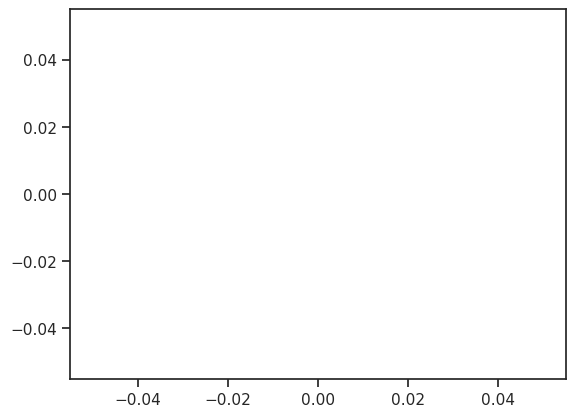

In [120]:

 
# training parameters
n_epochs = 5
batch_size = 20
batches_per_epoch = len(X) // batch_size
loss_history = []
 
for epoch in range(n_epochs):
    loss = 0
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X[start:start+batch_size]
            y_batch = y[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
    print(loss)
    loss_history += loss
plt.plot([i for i in range(len(loss_history))],loss_history)

In [121]:
torch.save(model.state_dict(), 'particleclassifier.torch')

In [122]:

X = torch.tensor(X_test.values, dtype=torch.float32)
y_pred = model(X)
y_pred = y_pred.detach().numpy()


In [123]:

y_pred.transpose()[0]

array([ -5.2948213, -21.50788  , -20.416594 , ..., -18.632578 ,
        16.331472 , -23.114084 ], dtype=float32)

In [124]:
X_test['pid'] = Y_test
X_test['pid_pred0'], X_test['pid_pred1'], X_test['pid_pred2'] = y_pred.transpose() 

<Axes: >

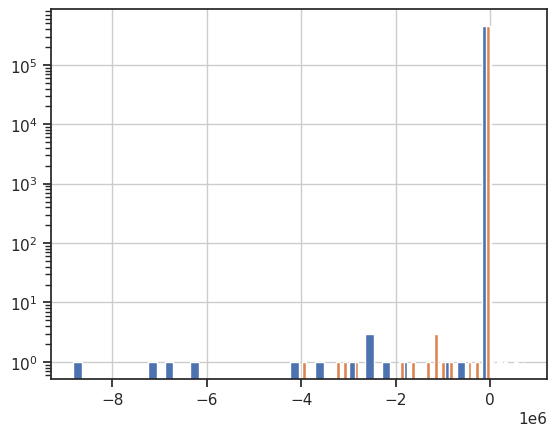

In [125]:
X_test['pid_pred0'].hist(bins=50,log=True)
X_test['pid_pred1'].hist(bins=50, log=True)
X_test['pid_pred2'].hist(bins=50,log=True)

226581
226889
226566
323
protons:
efficiency = 99.99337985091424%
purity = 99.85763963876609%


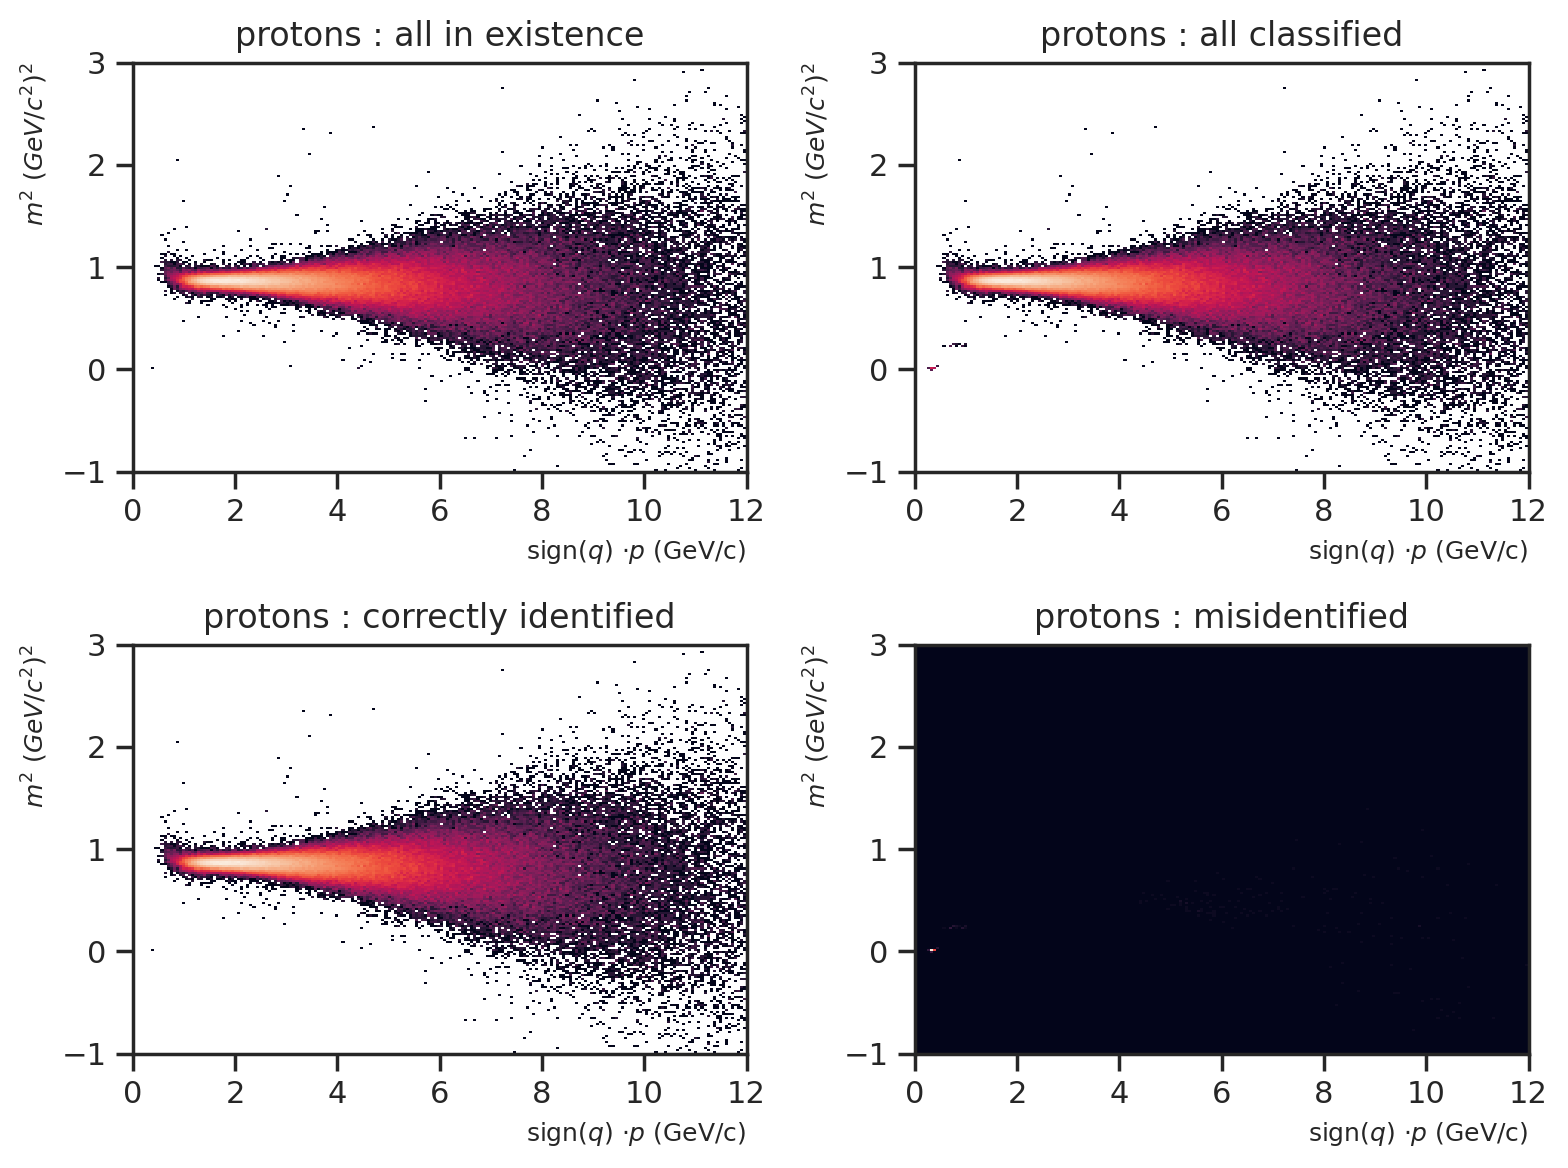

19208
19377
19023
354
kaons:
efficiency = 99.03685964181591%
purity = 98.17309180987769%


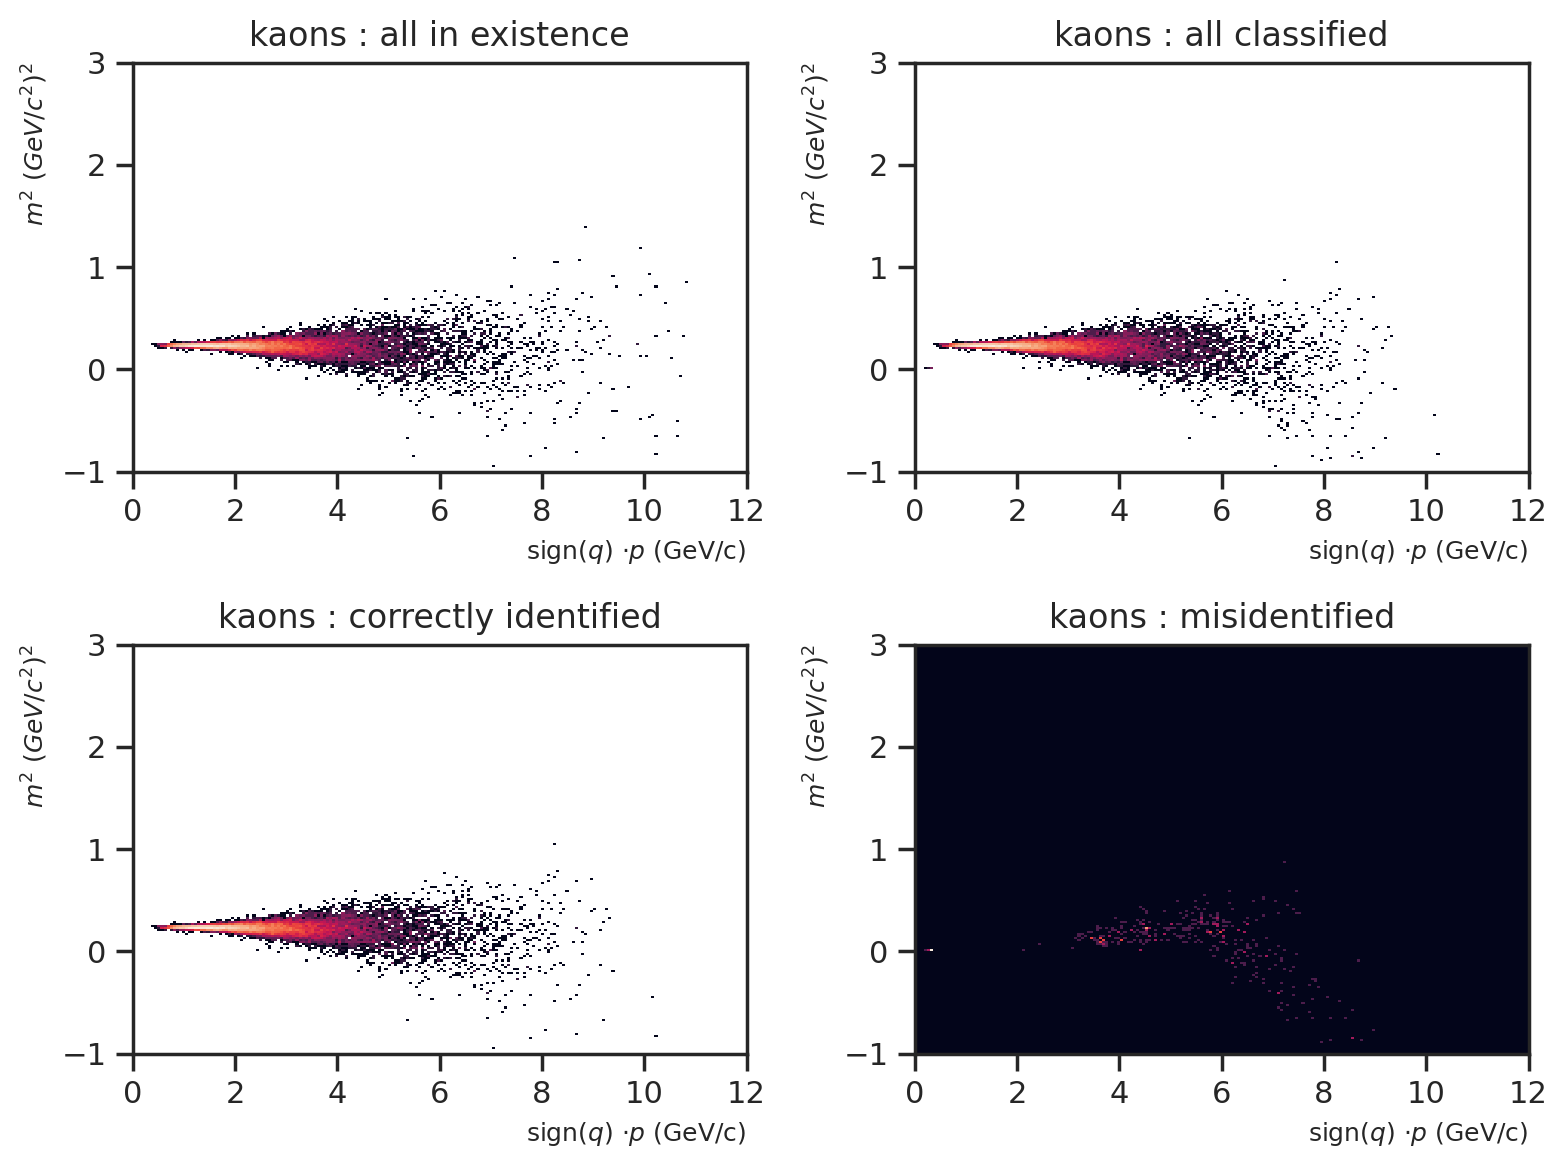

208687
208210
208193
17
pions:
efficiency = 99.7632818527268%
purity = 99.99183516641853%


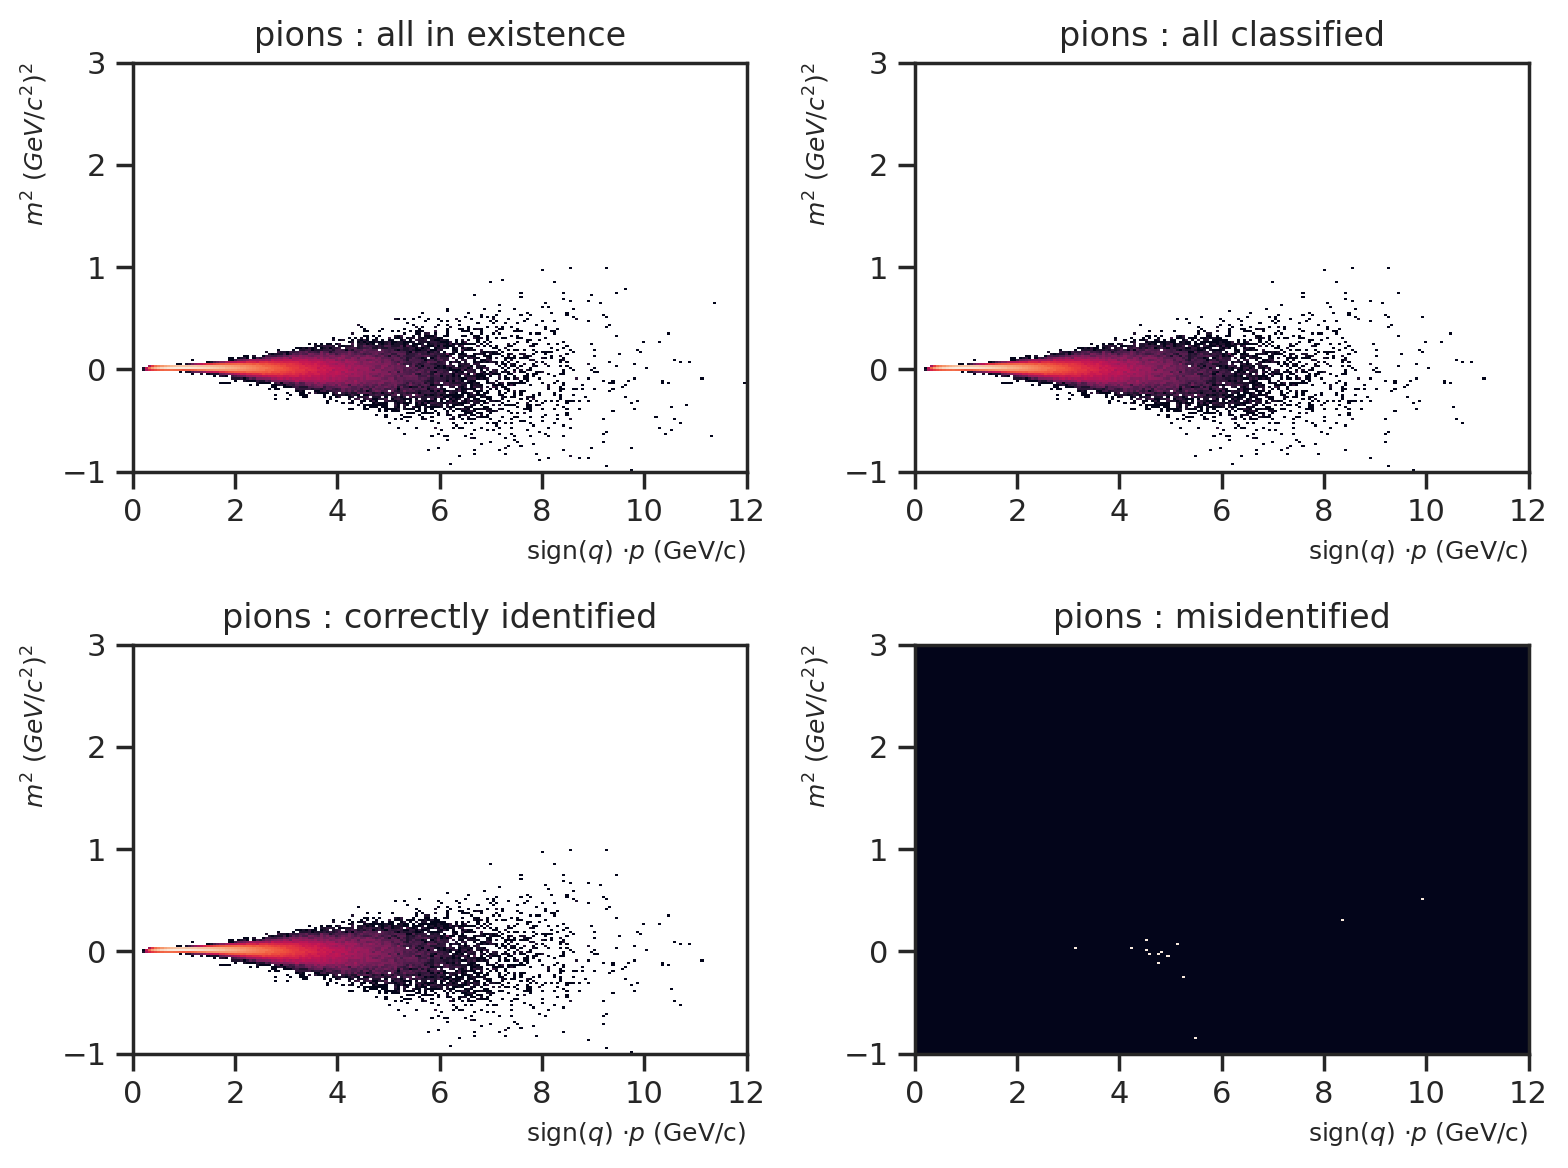

In [127]:

from matplotlib import pyplot as plt
import matplotlib



def selection(df, key):
    return df.loc[(df[key] >= df['pid_pred0']) & (df[key] >= df['pid_pred1']) & (df[key] >= df['pid_pred2']) ] #and df[key]/(df['pid_pred0'] + df['pid_pred1'] + df['pid_pred2']) > minpurity

def draw_tof_plot(df : pd.DataFrame, pid:int, particle_name ):
    key = f'pid_pred{pid}'

    fig, ax = plt.subplots(2,2,figsize=(8,6), dpi=200)
    
    all_protons = df.loc[df['pid'] == pid]
    print(len(all_protons))
    ax[0,0].hist2d(all_protons['p'], all_protons['mass2'], bins=200, norm=matplotlib.colors.LogNorm(), range=[(0,12), (-1,3)])
    
    all_identified = selection(df, key)
    print(len(all_identified))
    ax[0,1].hist2d(all_identified['p'], all_identified['mass2'], bins=200, norm=matplotlib.colors.LogNorm(), range=[(0,12), (-1,3)])

    well_identified=all_identified.loc[df['pid'] == pid]
    print(len(well_identified))
    ax[1,0].hist2d(well_identified['p'], well_identified['mass2'], bins=200, norm=matplotlib.colors.LogNorm(), range=[(0,12), (-1,3)])

    misidentified=all_identified.loc[df['pid'] != pid]
    print(len(misidentified))
    ax[1,1].hist2d(misidentified['p'], misidentified['mass2'], bins=200, range=[(0,12), (-1,3)])
    print(f"{particle_name}:")
    print(f"efficiency = {100*len(well_identified)/len(all_protons)}%")
    print(f"purity = {100*len(well_identified)/len(all_identified)}%")

    x_axis_name = r"sign($q$) $\cdot p$ (GeV/c)"
    y_axis_name = r"$m^2$ $(GeV/c^2)^2$"

    ax[0,0].set_xlabel(x_axis_name, fontsize=9, loc="right")
    ax[0,0].set_ylabel(y_axis_name, fontsize=9, loc="top")   
    ax[0,1].set_xlabel(x_axis_name, fontsize=9, loc="right")
    ax[0,1].set_ylabel(y_axis_name, fontsize=9, loc="top")   
    ax[1,0].set_xlabel(x_axis_name, fontsize=9, loc="right")
    ax[1,0].set_ylabel(y_axis_name, fontsize=9, loc="top")   
    ax[1,1].set_xlabel(x_axis_name, fontsize=9, loc="right")
    ax[1,1].set_ylabel(y_axis_name, fontsize=9, loc="top")   

    ax[0,0].set_title(f'{particle_name} : all in existence')
    ax[0,1].set_title(f'{particle_name} : all classified')
    ax[1,0].set_title(f'{particle_name} : correctly identified')
    ax[1,1].set_title(f'{particle_name} : misidentified')
    fig.tight_layout()
    plt.show()

draw_tof_plot(X_test, 0,'protons')
draw_tof_plot(X_test, 1,'kaons')
draw_tof_plot(X_test, 2,'pions')